In [ ]:
%%capture
!pip install tensorflow_addons
!pip install tensorflow_text

In [ ]:
import numpy as np
import pandas as pd
import random, io, os, datetime, glob
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
print('Tensorflow Hub version: {}'.format(hub.__version__))

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Tensorflow version: 2.4.1
Tensorflow Hub version: 0.11.0


In [ ]:
!nvidia-smi

Sun Feb 28 18:16:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameters

In [ ]:
BATCH_SIZE = 64

## Load HuffPost data

Number of news: 200853
Number of min, max, avg characters in "headline_char_len" column: 0, 320, 57
Number of min, max, avg words in "headline_word_len" column: 0, 44, 9
1269                Corruption Is Bad
1888               Meeting Mr. Wright
4975      Re-Introducing The Flipside
7650                   Truth And Lies
7776                    An NRA World?
                     ...             
200751            Darkness Ain't Cool
200759          Creating Shared Value
200803                   On the Fence
200819             Femme Invisibility
200845                       Web Wars
Name: headline, Length: 5022, dtype: object
Number of headlines less than threshold 5022


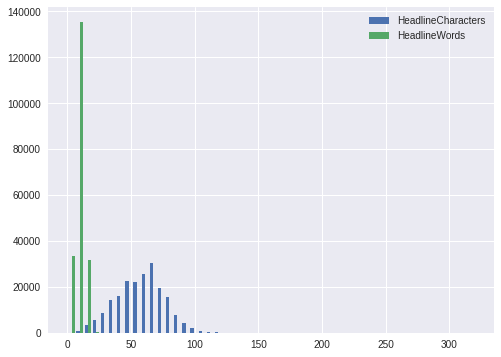

 
Number of min, max, avg characters in "short_description_char_len" column: 0, 1472, 114
Number of min, max, avg words in "short_description_word_len" column: 0, 243, 19
         short_description        category
69        Can you believe?    QUEER VOICES
105            What a god.   ENTERTAINMENT
114     "Pot meet kettle."        POLITICS
141                    😻😻😻      WEIRD NEWS
164      Under $1 million?          COMEDY
...                    ...             ...
198250                        QUEER VOICES
198265                         ENVIRONMENT
200129                              IMPACT
200191                        QUEER VOICES
200266                      STYLE & BEAUTY

[24297 rows x 2 columns]
Number of short_descriptions less than threshold 24297


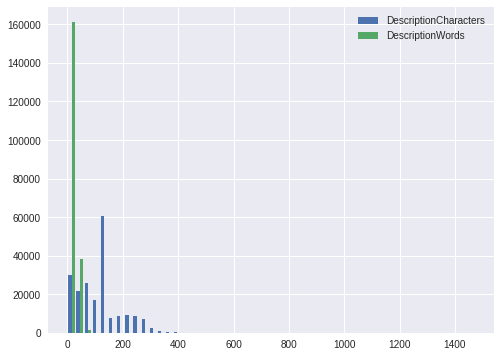

 
Number of min, max, avg characters in "headline_description_char_len" column: 2, 1488, 174
Number of min, max, avg words in "headline_description_word_len" column: 1, 245, 29
                                     headline_description        category
448     Chrissy Teigen And John Legend Welcome Baby Bo...   ENTERTAINMENT
845     This 'Pollen Bomb' Is Every Allergy Sufferer's...      WEIRD NEWS
1690    'Family Guy' Wickedly Pranks Emmy Voters. We h...   ENTERTAINMENT
2319    4 Notorious Hurricane Names You'll Never Hear ...      WORLD NEWS
3426    'The Simpsons' Predicted The Downfall Of Toys ...   ENTERTAINMENT
...                                                   ...             ...
185958  Watermelon Recipes To Eat All Summer Long. You...    FOOD & DRINK
186031  How To BBQ: Grill Anything Safely. Courtesy of...        WELLNESS
189660  A Landscape of Irrational Exuberance: This Art...  CULTURE & ARTS
192040  Parenting After Divorce. Parenting changes aft...         DIVORCE
195169  H

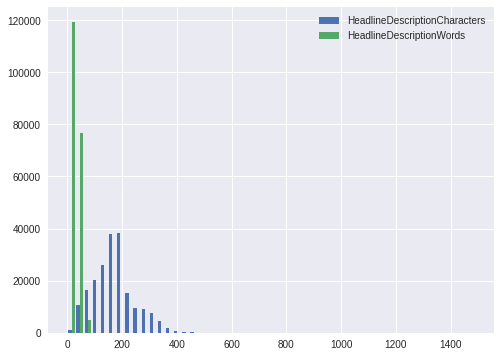

,category,headline,authors,link,short_description,date,category_id,headline_char_len,headline_word_len,short_description_char_len,short_description_word_len,headline_description,headline_description_char_len,headline_description_word_len
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,0,64,14,76,13,There Were 2 Mass Shootings In Texas Last Week...,142,27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,1,75,14,24,6,Will Smith Joins Diplo And Nicky Jam For The 2...,101,20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,1,47,10,87,15,Hugh Grant Marries For The First Time At Age 5...,136,25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,1,69,11,86,14,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,157,25
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,1,71,13,87,13,Julianna Margulies Uses Donald Trump Poop Bags...,160,26


In [ ]:
df = pd.read_json('/content/drive/MyDrive/Capital_Market/Neural_Returns/Demo_Data/NLP_Classification/HuffPost_News/News_Category_Dataset_v2.json', lines=True)

df['category_id'] = pd.factorize(df['category'])[0]
df['headline_char_len'] = df['headline'].str.len()
df['headline_word_len'] = df['headline'].str.split().apply(len)
df['short_description_char_len'] = df['short_description'].str.len()
df['short_description_word_len'] = df['short_description'].str.split().apply(len)

df['headline_description'] = df['headline'] + '. ' + df['short_description']
df['headline_description_char_len'] = df['headline_description'].str.len()
df['headline_description_word_len'] = df['headline_description'].str.split().apply(len)

print('Number of news:', len(df))
print('=================================')
print('Number of min, max, avg characters in "headline_char_len" column: {}, {}, {}'.format(df['headline_char_len'].min(), df['headline_char_len'].max(), int(df['headline_char_len'].mean())))
print('Number of min, max, avg words in "headline_word_len" column: {}, {}, {}'.format(df['headline_word_len'].min(), df['headline_word_len'].max(), int(df['headline_word_len'].mean())))
print('=================================')
print(df.loc[df['headline_word_len'] <= 3]['headline'])
print('Number of headlines less than threshold', len(df.loc[df['headline_word_len'] <= 3]))
plt.figure(figsize=(8,6))
plt.hist([df['headline_char_len'], df['headline_word_len']], 50, label=['HeadlineCharacters', 'HeadlineWords', 'DescriptionCharacters', 'DescriptionWords'])
plt.legend(loc='upper right')
plt.show()
print('==================================================================')
print(' ')

print('Number of min, max, avg characters in "short_description_char_len" column: {}, {}, {}'.format(df['short_description_char_len'].min(), df['short_description_char_len'].max(), int(df['short_description_char_len'].mean())))
print('Number of min, max, avg words in "short_description_word_len" column: {}, {}, {}'.format(df['short_description_word_len'].min(), df['short_description_word_len'].max(), int(df['short_description_word_len'].mean())))
print('=================================')
print(df.loc[df['short_description_word_len'] <= 3][['short_description', 'category']])
print('Number of short_descriptions less than threshold', len(df.loc[df['short_description_word_len'] <= 3]))
plt.figure(figsize=(8,6))
plt.hist([df['short_description_char_len'], df['short_description_word_len']], 50, label=['DescriptionCharacters', 'DescriptionWords'])
plt.legend(loc='upper right')
plt.show()
print('==================================================================')
print(' ')

print('Number of min, max, avg characters in "headline_description_char_len" column: {}, {}, {}'.format(df['headline_description_char_len'].min(), df['headline_description_char_len'].max(), int(df['headline_description_char_len'].mean())))
print('Number of min, max, avg words in "headline_description_word_len" column: {}, {}, {}'.format(df['headline_description_word_len'].min(), df['headline_description_word_len'].max(), int(df['headline_description_word_len'].mean())))
print('=================================')
print(df.loc[df['headline_description_word_len'] == 10][['headline_description', 'category']])
print('Number of short_descriptions less than threshold', len(df.loc[df['headline_description_word_len'] == 10]))
plt.figure(figsize=(8,6))
plt.hist([df['headline_description_char_len'], df['headline_description_word_len']], 50, label=['HeadlineDescriptionCharacters', 'HeadlineDescriptionWords'])
plt.legend(loc='upper right')
plt.show()
print('==================================================================')
print(' ')

df.head()

## Clean data - Remove non-wanted records

In [ ]:
#Remove sequences wit are too short
df = df[df['headline_description_word_len'] >= 10]
df.reset_index(drop=True, inplace=True)

print('Number of total news records: {}'.format(len(df)))
print(df.groupby('category').agg({'category_id':['count'],}))#.count()['category_id'])
print(df.groupby('category').count()['category_id']/len(df))#)
df.tail()

Number of total news records: 189339
               category_id
                     count
category                  
ARTS                  1236
ARTS & CULTURE        1338
BLACK VOICES          4328
BUSINESS              5400
COLLEGE               1042
COMEDY                4637
CRIME                 2969
CULTURE & ARTS        1014
DIVORCE               3426
EDUCATION              934
ENTERTAINMENT        14494
ENVIRONMENT           1321
FIFTY                 1189
FOOD & DRINK          6157
GOOD NEWS             1291
GREEN                 2299
HEALTHY LIVING        5742
HOME & LIVING         4180
IMPACT                3305
LATINO VOICES         1087
MEDIA                 2467
MONEY                 1706
PARENTING             8671
PARENTS               3741
POLITICS             31034
QUEER VOICES          6027
RELIGION              2151
SCIENCE               1901
SPORTS                4440
STYLE                 1839
STYLE & BEAUTY        9630
TASTE                 1977
TECH              

,category,headline,authors,link,short_description,date,category_id,headline_char_len,headline_word_len,short_description_char_len,short_description_word_len,headline_description,headline_description_char_len,headline_description_word_len
189334,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28,14,58,8,124,18,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,184,26
189335,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28,10,69,10,122,20,Maria Sharapova Stunned By Victoria Azarenka I...,193,30
189336,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28,10,99,16,121,24,"Giants Over Patriots, Jets Over Colts Among M...",222,40
189337,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28,10,53,8,120,20,Aldon Smith Arrested: 49ers Linebacker Busted ...,175,28
189338,SPORTS,Dwight Howard Rips Teammates After Magic Loss ...,,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...,2012-01-28,10,56,9,122,19,Dwight Howard Rips Teammates After Magic Loss ...,180,28


## Split data in training and validation dataset

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


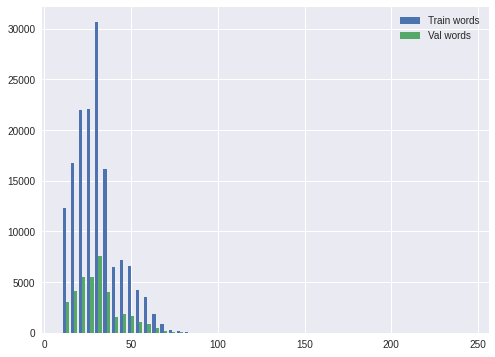

Category IDs
category        category_id
ARTS            30               989
ARTS & CULTURE  21              1064
BLACK VOICES    6               3484
BUSINESS        11              4300
COLLEGE         19               849
COMEDY          8               3707
CRIME           0               2354
CULTURE & ARTS  40               825
DIVORCE         35              2736
EDUCATION       18               746
ENTERTAINMENT   1              11682
ENVIRONMENT     39              1039
FIFTY           29               947
FOOD & DRINK    37              5001
GOOD NEWS       27              1043
GREEN           23              1842
HEALTHY LIVING  25              4626
HOME & LIVING   33              3349
IMPACT          3               2644
LATINO VOICES   17               868
MEDIA           13              1981
MONEY           38              1361
PARENTING       32              6838
PARENTS         20              2989
POLITICS        4              24803
QUEER VOICES    9               47

In [ ]:
df_train = df.sample(frac=0.8, random_state=3, replace=False)
df_val = df.drop(df_train.index)

df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

plt.figure(figsize=(8,6))
plt.hist([df_train['headline_description_word_len'], df_val['headline_description_word_len']], 50, label=['Train words', 'Val words'])
plt.legend(loc='upper right')
plt.show()

print('Category IDs')
print(df_train.groupby(['category','category_id']).size())
print('==============================================================')
print('Class distribution')
class_distribution = df_train.groupby('category').count()['category_id']/df_train.groupby('category').count().sum()[0]
print('Number of classes: {}'.format(len(class_distribution)))
print(class_distribution)
print('==============================================================')

print('Reversed class distribution')
reverese_class_distribution = (1/(df_train.groupby('category').count()['category_id']/df_train.groupby('category').count().sum()[0]))
reverse_sum = 1/reverese_class_distribution.sum()
scaled_reverese_class_dist = reverese_class_distribution * reverse_sum
print(scaled_reverese_class_dist)
print(scaled_reverese_class_dist.sum())

## Load Albert Files

In [ ]:
albert_tokenizer = hub.KerasLayer("http://tfhub.dev/tensorflow/albert_en_preprocess/2")
albert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/2", trainable=True)

## DataGenerator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, data, tokenizer, batch_size):
    self.data = data
    self.tokenizer = tokenizer
    self.batch_size = batch_size

  def __len__(self):
    return (np.ceil(len(self.data) / float(self.batch_size))).astype(np.int)

  def __getitem__(self, idx):
    df_batch = self.data.iloc[idx*self.batch_size : ((idx+1)*self.batch_size)]
    
    preprocessed_tokens = self.tokenizer(tf.constant(df_batch['headline_description'].tolist())) 
    y = df_batch['category_id'].values
    return [preprocessed_tokens['input_word_ids'], preprocessed_tokens['input_mask'], preprocessed_tokens['input_type_ids']], y


train_gen = DataGenerator(df_train, albert_tokenizer, BATCH_SIZE)
val_gen = DataGenerator(df_val, albert_tokenizer, BATCH_SIZE)

## Construct Siamese ALBERT model architecture

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32)
input_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32)
input_type_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32)
  
albert_layer = albert_encoder({'input_word_ids': input_word_ids, 'input_mask': input_mask, 'input_type_ids': input_type_ids})['pooled_output']
dense_layer = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', name='dense_vector_reduction')(albert_layer)
out = tf.keras.layers.Dense(64, activation=None, name='out')(dense_layer)
out = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(out)
model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=out, name="embedding_model")
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss=tfa.losses.TripletSemiHardLoss())


Model: "embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 11683584    input_5[0][0]                    
                                                                 input_6[0][0]      

## Compile Siamese ALBERT model

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Capital_Market/Neural_Returns/Models/20210228_SiameseTriplet_AlbertBase_epoch{epoch:02d}_val-loss{val_loss:.6f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1),]

# Train the network
history = model.fit(train_gen,
                    steps_per_epoch = len(df_train)//BATCH_SIZE+1,
                    batch_size = None,
                    verbose = 1,
                    epochs = 25,
                    shuffle = True,
                    validation_data = val_gen,
                    validation_steps = len(df_val)//BATCH_SIZE+1,
                    callbacks = callbacks,                    
                    max_queue_size = 3,)

Epoch 1/25
2367/2367 [==============================] - 2162s 913ms/step - loss: 0.8138 - val_loss: 0.7727

Epoch 00001: val_loss improved from inf to 0.77272, saving model to /content/drive/My Drive/Capital_Market/Neural_Returns/Models/20210228_SiameseTriplet_AlbertBase_epoch01_val-loss0.772721.hdf5
Epoch 2/25
2367/2367 [==============================] - 2156s 911ms/step - loss: 0.7354 - val_loss: 0.7703

Epoch 00002: val_loss improved from 0.77272 to 0.77029, saving model to /content/drive/My Drive/Capital_Market/Neural_Returns/Models/20210228_SiameseTriplet_AlbertBase_epoch02_val-loss0.770294.hdf5
Epoch 3/25
2367/2367 [==============================] - 2155s 911ms/step - loss: 0.6960 - val_loss: 0.7669

Epoch 00003: val_loss improved from 0.77029 to 0.76687, saving model to /content/drive/My Drive/Capital_Market/Neural_Returns/Models/20210228_SiameseTriplet_AlbertBase_epoch03_val-loss0.766868.hdf5
Epoch 4/25
2367/2367 [==============================] - 2153s 909ms/step - loss: 0.666

## Model training metrcis

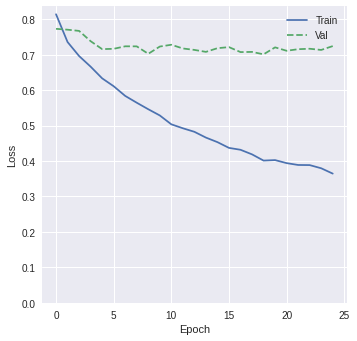

In [ ]:
def plot_metrics(history):
  metrics = ['loss']
  plt.figure(figsize=(12,12))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

plot_metrics(history)